# Share of High-Solar-Exposure (HSE) segments

Find out how much of the route is covered with HSE segments. This shows the potential critical heat stress aggregated per time of day.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from pathlib import Path
from tqdm import tqdm

# Ignore FutureWarnings from geopandas
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', message='.*initial implementation of Parquet.*')
# Ignore SettingWithCopyWarning from (geo-)pandas
pd.options.mode.chained_assignment = None  # default='warn'


# Config
day = 170
sensitivity_factor = 1.0

in_dir = Path(f'../../export/{day}/{sensitivity_factor}/exportdata')
out_dir = Path(in_dir.parent / 'analysis')
out_dir.mkdir(parents=True, exist_ok=True)

tod_list = ['10am', '1pm', '4pm', '7pm']
colors = {
    '10am': 'yellowgreen',
    '1pm': 'darkgoldenrod',
    '4pm': 'plum',
    '7pm': 'tab:blue',
}
default_type = 'shortest'
optimized_type = 'shaded'
custom_labels = [default_type.title(), 'Shaded']

high_sol_expo = 90
low_sol_expo = 50

n_routes = 625 * 16 # config file parameters (n_routes * poi types)

sns.set_theme(style='whitegrid')
sns.set_context('paper')

xlim = (-2, 102)
ylim = (-2, 102)
ylim_neg=(2, -102)

y_value = 'hse_share'

In [2]:
# Helper functions
def tod_format(tod):
    """Returns the formatted time of day string"""
    return tod[:-2] + ' ' + tod[-2:].upper()

In [3]:
# Calculate HSE share of optimized routes
hse_data = []

for tod in tod_list:
    print(f'Processing {tod} data...')
    gdf = gpd.read_feather(in_dir / f'segments/segments_{tod}.feather')
    gdf.to_crs(epsg=25832, inplace=True)
    
    for route_i in tqdm(range(1, n_routes + 1)):
        gdf_ex = gdf[gdf['trip_id'] == route_i]
        total_length = gdf_ex['geom'].length.sum()

        gdf_hse = gdf_ex[gdf_ex[f'sol_expo_{tod}'] >= high_sol_expo]
        hse_length = gdf_hse['geom'].length.sum()

        if hse_length > 0.0:
            hse_share = (hse_length / total_length) * 100
        else:
            hse_share = 0.0

        route_data = {
            'trip_id': route_i,
            'time_of_day': tod,
            'route_type': f'{optimized_type} route',
            'length': round(total_length, 2),
            'hse_length': round(hse_length, 2),
            'hse_share': round(hse_share, 2)
        }
        hse_data.append(route_data)

Processing 10am data...


100%|██████████| 10000/10000 [00:08<00:00, 1207.24it/s]


Processing 1pm data...


100%|██████████| 10000/10000 [00:08<00:00, 1116.11it/s]


Processing 4pm data...


100%|██████████| 10000/10000 [00:09<00:00, 1097.98it/s]


Processing 7pm data...


100%|██████████| 10000/10000 [00:08<00:00, 1113.47it/s]


In [4]:
# Read data of default routes
gdf = gpd.read_feather(in_dir / f'segments/segments_{default_type}.feather')
gdf.to_crs(epsg=25832, inplace=True)

In [5]:
# Calculate HSE share for default routes
hse_data_default = []

for route_i in tqdm(range(1, n_routes + 1)):
    gdf_ex = gdf[gdf['trip_id'] == route_i]
    total_length = gdf_ex['geom'].length.sum()

    for tod in tod_list:
        gdf_hse = gdf_ex[gdf_ex[f'sol_expo_{tod}'] >= high_sol_expo]
        hse_length = gdf_hse['geom'].length.sum()

        if hse_length > 0.0:
            hse_share = (hse_length / total_length) * 100
        else:
            hse_share = 0.0

        route_data = {
            'trip_id': route_i,
            'time_of_day': tod,
            'route_type': f'{default_type} route',
            'length': round(total_length, 2),
            'hse_length': round(hse_length, 2),
            'hse_share': round(hse_share, 2)
        }
        hse_data_default.append(route_data)

100%|██████████| 10000/10000 [00:18<00:00, 528.39it/s]


In [6]:
len(hse_data), len(hse_data_default)

(40000, 40000)

In [7]:
# Merge deault and optimized data
hse_df = pd.DataFrame(hse_data + hse_data_default)
hse_df.sort_values(by=['trip_id', 'time_of_day'], inplace=True)
hse_df.reset_index(drop=True, inplace=True)

hse_df.to_feather(out_dir / f'{y_value}.feather')

If re-running, start from here to skip preprocessing

In [8]:
hse_df = pd.read_feather(out_dir / f'{y_value}.feather')

In [9]:
def permutation_test(dfex, n_perm=9999):
    """Use permutation test to compare the mean differences in HSE shares between default and optimized routes."""
    df1 = dfex[dfex['route_type'] == f'{default_type} route'].sort_values('trip_id')
    df2 = dfex[dfex['route_type'] == f'{optimized_type} route'].sort_values('trip_id')
    assert all(df1['trip_id'].values == df2['trip_id'].values), "Trip IDs must match between default and optimized routes"

    x = df1[f'hse_share'].values
    y = df2[f'hse_share'].values
    assert x.shape == y.shape, "Input arrays must have the same shape"

    differences = x - y
    obs_mean_diff = np.mean(differences)

    signs = np.random.choice([-1, 1], size=(n_perm, len(differences)))
    permuted_means = np.mean(signs * differences, axis=1)

    p_value = np.mean(permuted_means >= obs_mean_diff) # h1: the mean of the permuted differences is greater than or equal to the observed mean difference (hse shares of optimized route is lower than default route)

    if p_value < 0.001:
        sig_level = '***'
    elif p_value < 0.01:
        sig_level = '**'
    elif p_value < 0.05:
        sig_level = '*'
    else:
        sig_level = 'ns'

    cohens_d = obs_mean_diff / np.std(differences, ddof=1)

    return obs_mean_diff, p_value, sig_level, cohens_d

10am: obs_mean=7.7440, p_value=0.0000, significance=***, cohens_d=0.5434
10am - hse_share - shortest - Median: 37.81 - Max: 100.0 - Min: 0.0
10am - hse_share - shaded - Median: 23.985 - Max: 100.0 - Min: 0.0
1pm: obs_mean=7.5072, p_value=0.0000, significance=***, cohens_d=0.5635
1pm - hse_share - shortest - Median: 42.68 - Max: 100.0 - Min: 0.0
1pm - hse_share - shaded - Median: 29.755 - Max: 100.0 - Min: 0.0
4pm: obs_mean=8.0346, p_value=0.0000, significance=***, cohens_d=0.5692
4pm - hse_share - shortest - Median: 39.685 - Max: 100.0 - Min: 0.0
4pm - hse_share - shaded - Median: 25.105 - Max: 100.0 - Min: 0.0
7pm: obs_mean=7.5484, p_value=0.0000, significance=***, cohens_d=0.5189
7pm - hse_share - shortest - Median: 33.045 - Max: 100.0 - Min: 0.0
7pm - hse_share - shaded - Median: 19.585 - Max: 100.0 - Min: 0.0


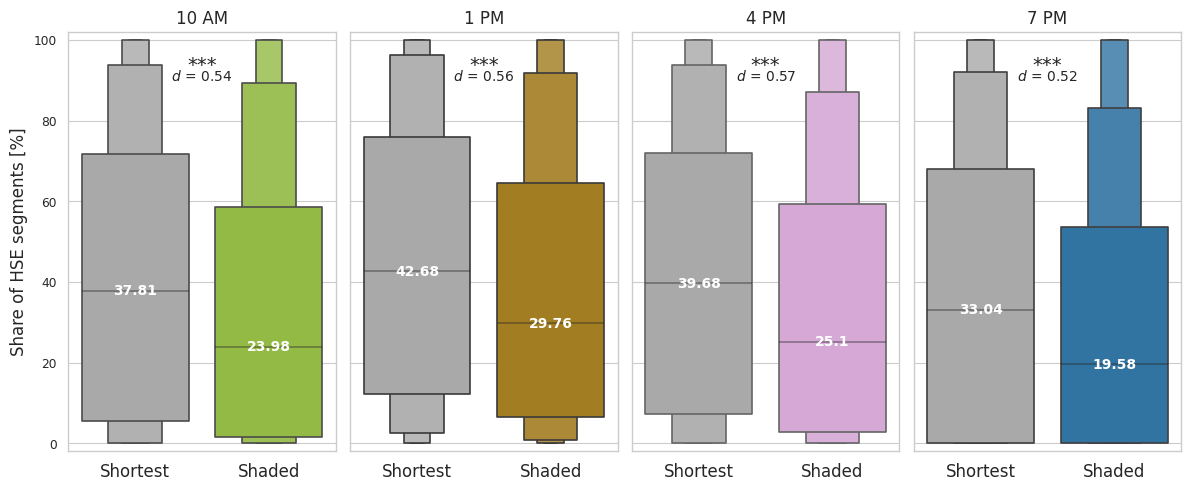

In [10]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(12, 5), sharey=True)

for col, (tod, ax) in enumerate(zip(tod_list, axes)):
    dfex = hse_df[hse_df['time_of_day'] == tod]
    g = sns.boxenplot(data=dfex, x='route_type', y=y_value, order=[f'{default_type} route', f'{optimized_type} route'], palette={f'{default_type} route': 'darkgrey', f'{optimized_type} route': colors[tod]},  ax=ax)
    g.set_xlabel('')
    g.set_ylabel('Share of HSE segments [%]', fontsize=12) if col == 0 else g.set_ylabel('')
    g.set_ylim(ylim)
    g.set_title(tod_format(tod), fontsize=12)
    median_default = dfex[dfex['route_type'] == f'{default_type} route'][y_value].median()
    median_time = dfex[dfex['route_type'] == f'{optimized_type} route'][y_value].median()
    max_default = dfex[dfex['route_type'] == f'{default_type} route'][y_value].max()
    max_time = dfex[dfex['route_type'] == f'{optimized_type} route'][y_value].max()
    min_default = dfex[dfex['route_type'] == f'{default_type} route'][y_value].min()
    min_time = dfex[dfex['route_type'] == f'{optimized_type} route'][y_value].min()
    g.text(0, median_default, f'{round(median_default, 2)}', ha='center', va='center', fontweight='bold', fontsize=10, color='white')
    g.text(1, median_time, f'{round(median_time, 2)}', ha='center', va='center', fontweight='bold', fontsize=10, color='white')
    g.set_xticklabels(custom_labels, fontsize=12)

    obs_mean, p_value, sig_level, cohens_d = permutation_test(dfex)
    g.text(0.5, 92.5, sig_level, ha='center', fontsize=14)
    g.text(0.5, 90, rf'$d$ = {cohens_d:.2f}', ha='center', fontsize=10)
    print(f'{tod}: obs_mean={obs_mean:.4f}, p_value={p_value:.4f}, significance={sig_level}, cohens_d={cohens_d:.4f}')

    print(f'{tod} - {y_value} - {default_type} - Median: {median_default} - Max: {max_default} - Min: {min_default}')
    print(f'{tod} - {y_value} - {optimized_type} - Median: {median_time} - Max: {max_time} - Min: {min_time}')

plt.tight_layout()
plt.savefig(out_dir / f'{y_value}.png', dpi=300, bbox_inches='tight')
plt.show()